In [1]:
import numpy as np
import pandas as pd
from scipy.io import mmread

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)


In [2]:

import anndata as ad
import scanpy as sc
import maxfuse as mf

/home/jayantjha/anaconda3/envs/maxfuse/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# read in protein data
protein = pd.read_csv("Protein.csv") # 10k cells (protein)
protein_names = protein.X
protein = protein.drop('X', axis = 1)
# convert to AnnData
protein_adata = ad.AnnData(
    protein.to_numpy(), dtype=np.float32
)
protein_adata.var_names = protein.columns


In [4]:
protein.columns


Index(['CD80', 'CD86', 'CD274', 'CD273', 'CD275.1', 'CD11b.1', 'Galectin.9',
       'CD270', 'CD252', 'CD155',
       ...
       'CD161', 'CCR10', 'CD271', 'GP130', 'CD199', 'CD45RB', 'CD46',
       'VEGFR.3', 'CLEC2', 'CD26.2'],
      dtype='object', length=224)

In [5]:
# read in RNA data
rna = pd.read_csv("scRNA_Seq.csv") # rna count as sparse matrix, 10k cells (RNA)
rna_names = rna.X
rna = rna.drop('X', axis = 1)
# convert to AnnData
rna_adata = ad.AnnData(
    rna.to_numpy(), dtype=np.float32
)
rna_adata.var_names = rna.columns

In [6]:
rna.columns

Index(['HES4', 'ISG15', 'TTLL10', 'TNFRSF18', 'TNFRSF4', 'SMIM1', 'AJAP1',
       'TNFRSF25', 'UTS2', 'CA6',
       ...
       'AC011479.1', 'AC114752.2', 'NPHP3-AS1', 'SLC30A8', 'AC131971.1',
       'AP001999.1', 'LINC01579', 'HOXB9', 'IGHV5-10-1', 'AC011933.4'],
      dtype='object', length=2000)

In [7]:
correspondence = pd.read_csv('./data/protein_gene_conversion.csv')
correspondence.head()

,Protein name,RNA name
0,CD80,CD80
1,CD86,CD86
2,CD274,CD274
3,CD273,PDCD1LG2
4,CD275,ICOSLG


In [8]:
rna_protein_correspondence = []

for i in range(correspondence.shape[0]):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    if curr_protein_name not in protein_adata.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in rna_adata.var_names:
            rna_protein_correspondence.append([r, curr_protein_name])
            
rna_protein_correspondence = np.array(rna_protein_correspondence)

In [9]:
len(rna_protein_correspondence)

95

In [10]:
# Columns rna_shared and protein_shared are matched.
# One may encounter "Variable names are not unique" warning,
# this is fine and is because one RNA may encode multiple proteins and vice versa.
rna_shared = rna_adata[:, rna_protein_correspondence[:, 0]].copy()
protein_shared = protein_adata[:, rna_protein_correspondence[:, 1]].copy()

/home/jayantjha/anaconda3/envs/maxfuse/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jayantjha/anaconda3/envs/maxfuse/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [11]:
# Make sure no column is static

mask = (
    (rna_shared.X.std(axis=0) > 1e-5) 
    & (protein_shared.X.std(axis=0) > 1e-5)
)
rna_shared = rna_shared[:, mask].copy()
protein_shared = protein_shared[:, mask].copy()

/home/jayantjha/anaconda3/envs/maxfuse/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jayantjha/anaconda3/envs/maxfuse/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [12]:
# row sum for RNA
rna_counts = rna_shared.X.sum(axis=1)
# row sum for protein
protein_counts = protein_shared.X.sum(axis=1)
# take median of each and then take mean
target_sum = (np.median(rna_counts.copy()) + np.median(protein_counts.copy())) / 2

In [13]:
# process rna_shared
sc.pp.normalize_total(rna_shared, target_sum=target_sum)
sc.pp.log1p(rna_shared)
sc.pp.scale(rna_shared)

In [14]:
rna_shared = rna_shared.X.copy()

In [15]:
# process protein_shared
sc.pp.normalize_total(protein_shared, target_sum=target_sum)
sc.pp.log1p(protein_shared)
sc.pp.scale(protein_shared)

In [16]:
protein_shared = protein_shared.X.copy()

In [17]:
# process all RNA features
sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)
sc.pp.highly_variable_genes(rna_adata)
# only retain highly variable genes
rna_adata = rna_adata[:, rna_adata.var.highly_variable].copy()
sc.pp.scale(rna_adata)

In [18]:
# process all protein features
sc.pp.normalize_total(protein_adata)
sc.pp.log1p(protein_adata)
sc.pp.scale(protein_adata)

In [19]:
# make sure no feature is static
rna_active = rna_adata.X
protein_active = protein_adata.X
rna_active = rna_active[:, rna_active.std(axis=0) > 1e-5]
protein_active = protein_active[:, protein_active.std(axis=0) > 1e-5]

In [20]:
# inspect shape of the four matrices
print(rna_active.shape)
print(protein_active.shape)
print(rna_shared.shape)
print(protein_shared.shape)

(10000, 272)
(10000, 224)
(10000, 95)
(10000, 95)


In [21]:
# call constructor for Fusor object
# which is the main object for running MaxFuse pipeline
fusor = mf.model.Fusor(
    shared_arr1=rna_shared,
    shared_arr2=protein_shared,
    active_arr1=rna_active,
    active_arr2=protein_active,
    labels1=None,
    labels2=None
)

In [22]:
fusor.split_into_batches(
    max_outward_size=5000,
    matching_ratio=3,
    metacell_size=2,
    verbose=True
)

The first data is split into 1 batches, average batch size is 10000, and max batch size is 10000.
The second data is split into 1 batches, average batch size is 10000, and max batch size is 10000.
Batch to batch correspondence is:
  ['0<->0'].


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

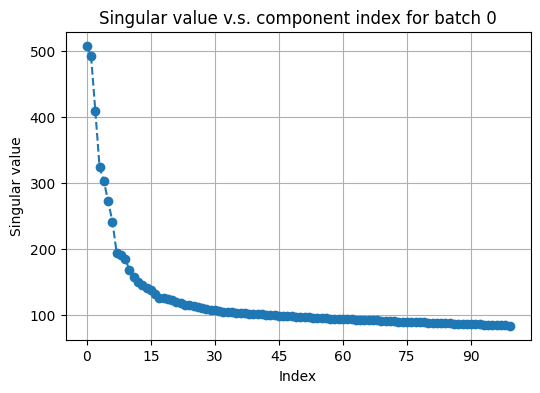

In [23]:
# plot top singular values of avtive_arr1 on a random batch
fusor.plot_singular_values(
    target='active_arr1',
    n_components=None # can also explicitly specify the number of components
)

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

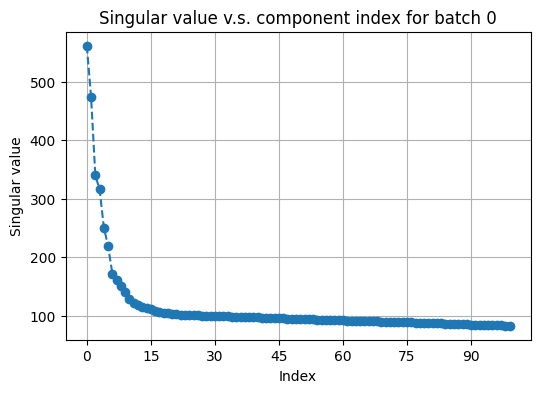

In [24]:
# plot top singular values of avtive_arr2 on a random batch
fusor.plot_singular_values(
    target='active_arr2',
    n_components=None
)

In [25]:
fusor.construct_graphs(
    n_neighbors1=15,
    n_neighbors2=15,
    svd_components1=30,
    svd_components2=30,
    resolution1=2,
    resolution2=2,
    # if two resolutions differ less than resolution_tol
    # then we do not distinguish between then
    resolution_tol=0.1,
    verbose=True
)

Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr1...
Now at batch 0...
Graph clustering finished!
Constructing neighborhood graphs for cells in arr2...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr2...
Now at batch 0...
Graph clustering finished!


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

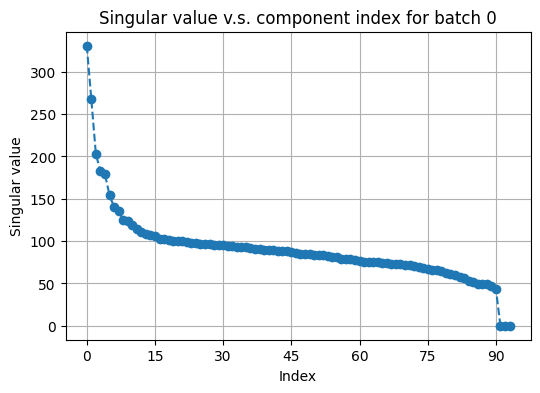

In [26]:
# plot top singular values of shared_arr1 on a random batch
fusor.plot_singular_values(
    target='shared_arr1',
    n_components=None,
)

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

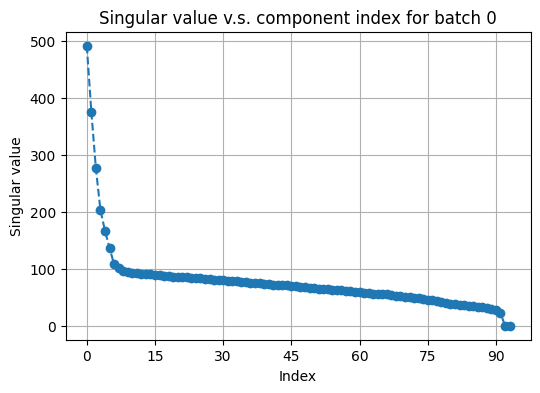

In [27]:
# plot top singular values of shared_arr2 on a random batch
fusor.plot_singular_values(
    target='shared_arr2',
    n_components=None
)

In [28]:
fusor.find_initial_pivots(
    wt1=0.7, wt2=0.7,
    svd_components1=25, svd_components2=20
)

Now at batch 0<->0...
Done!


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Canonical correlation v.s. component index for batch 0<->0'}, xlabel='Index', ylabel='Canonical correlation'>)

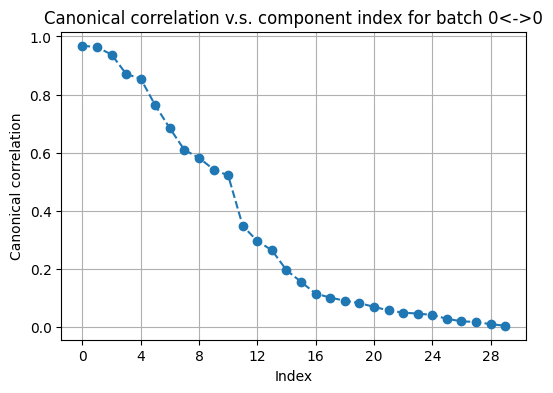

In [29]:
# plot top canonical correlations in a random batch
fusor.plot_canonical_correlations(
    svd_components1=30,
    svd_components2=30,
    cca_components=30
)

In [30]:
fusor.refine_pivots(
    wt1=0.7, wt2=0.7,
    svd_components1=30, svd_components2=30,
    cca_components=10,
    n_iters=3,
    randomized_svd=False, 
    svd_runs=1,
    verbose=True
)

Now at batch 0<->0...
Done!


In [31]:
fusor.filter_bad_matches(target='pivot', filter_prop=0.3)

Begin filtering...
Now at batch 0<->0...
3517/5024 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
6964/10000 cells in arr1 are selected as pivots.
3517/10000 cells in arr2 are selected as pivots.
Done!


In [32]:
pivot_matching = fusor.get_matching(target='pivot')

In [33]:
# We can inspect the first pivot pair.
[pivot_matching[0][0], pivot_matching[1][0], pivot_matching[2][0]]

[9985, 1, 0.9889714102579023]

In [34]:
rna_cca, protein_cca = fusor.get_embedding(
    active_arr1=fusor.active_arr1,
    active_arr2=fusor.active_arr2
)

In [35]:
rna_cca.shape



(10000, 10)

In [36]:
dim_use = 10 # dimensions of the CCA embedding to be used for UMAP etc

mf.metrics.get_foscttm(
    dist=mf.utils.cdist_correlation(rna_cca[:,:dim_use], protein_cca[:,:dim_use]),
    true_matching='identity'
)

0.07373107

In [37]:
cca_adata = ad.AnnData(
    np.concatenate((rna_cca[:,:dim_use], protein_cca[:,:dim_use]), axis=0), 
    dtype=np.float32
)
cca_adata.obs['data_type'] = ['rna'] * rna_cca.shape[0] + ['protein'] * protein_cca.shape[0]

In [38]:
cca_adata


AnnData object with n_obs × n_vars = 20000 × 10
    obs: 'data_type'

/home/jayantjha/anaconda3/envs/maxfuse/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


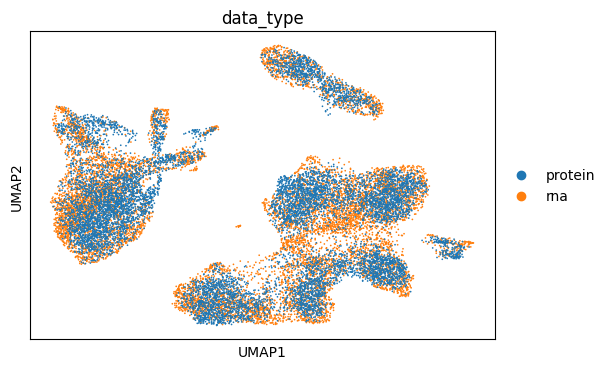

In [39]:
sc.pp.neighbors(cca_adata, n_neighbors=15)
sc.tl.umap(cca_adata)
sc.pl.umap(cca_adata, color='data_type')

In [40]:
fusor.propagate(
    svd_components1=30, 
    svd_components2=30, 
    wt1=0.7,
    wt2=0.7,
)

Now at batch 0<->0...
Done!


In [41]:
fusor.filter_bad_matches(
    target='propagated',
    filter_prop=0
)

Begin filtering...
Now at batch 0<->0...
7990/7990 pairs of matched cells remain after the filtering.
Scoring matched pairs...
Done!


In [42]:
full_matching = fusor.get_matching(order=(2, 1), target='full_data')

In [43]:
rna_cca, protein_cca = fusor.get_embedding(
    active_arr1=fusor.active_arr1,
    active_arr2=fusor.active_arr2
)


In [44]:
protein_cca.shape


(10000, 10)

In [45]:
final_data = np.vstack((rna_cca, protein_cca))

In [46]:
final_data.shape

(20000, 10)

In [47]:
type(protein_names)

pandas.core.series.Series

In [48]:
combined_names = pd.concat([rna_names, protein_names], ignore_index=True)

In [49]:
combined_names

0            E2L4_GCTTTCGTCCCAAGCG_rna
1              L4_CTGGACGAGCTGACCC_rna
2            E2L5_TTGCTGCTCAATCAGC_rna
3              L4_ACAACCAAGGTCCTGC_rna
4              L4_CTTCTCTAGCCGTTAT_rna
                     ...              
19995      L4_TCTTCCTGTCAGGTAG_protein
19996      L1_CCCTCTCAGACGCAGT_protein
19997    E2L2_AATTTCCAGGAGTCTG_protein
19998    E2L5_GTTTACTGTATCTCGA_protein
19999    E2L1_GTTAGACAGGGTGGGA_protein
Name: X, Length: 20000, dtype: object

In [50]:
from sklearn.cluster import KMeans

In [51]:
# Assuming data_1 is a (20000, 10) numpy array
num_clusters = 8  # Number of clusters

# Apply KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(final_data)

In [52]:
clusters

array([2, 2, 5, ..., 2, 5, 3], dtype=int32)

In [53]:
cca_adata.obs['celltype.l1'] = clusters


In [54]:
cca_adata


AnnData object with n_obs × n_vars = 20000 × 10
    obs: 'data_type', 'celltype.l1'
    uns: 'neighbors', 'umap', 'data_type_colors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

/home/jayantjha/anaconda3/envs/maxfuse/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


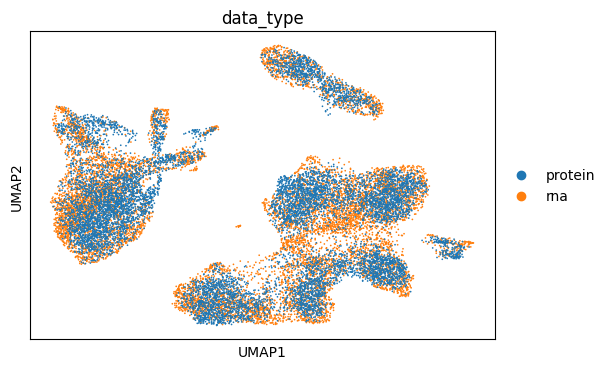

In [55]:
sc.pp.neighbors(cca_adata, n_neighbors=15)
sc.tl.umap(cca_adata)
sc.pl.umap(cca_adata, color='data_type')

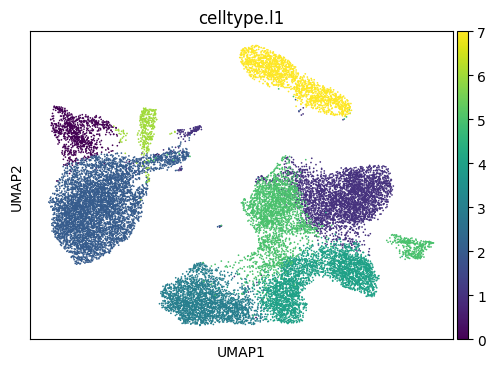

In [56]:
sc.pl.umap(cca_adata, color=['celltype.l1'])

In [57]:
combined_names = combined_names.to_frame(name = "Index")

In [58]:
combined_names


,Index
0,E2L4_GCTTTCGTCCCAAGCG_rna
1,L4_CTGGACGAGCTGACCC_rna
2,E2L5_TTGCTGCTCAATCAGC_rna
3,L4_ACAACCAAGGTCCTGC_rna
4,L4_CTTCTCTAGCCGTTAT_rna
...,...
19995,L4_TCTTCCTGTCAGGTAG_protein
19996,L1_CCCTCTCAGACGCAGT_protein
19997,E2L2_AATTTCCAGGAGTCTG_protein
19998,E2L5_GTTTACTGTATCTCGA_protein


In [59]:
final_embeddings = pd.DataFrame({"Index": combined_names.iloc[:, 0], "Expected": clusters})

In [60]:
final_embeddings

,Index,Expected
0,E2L4_GCTTTCGTCCCAAGCG_rna,2
1,L4_CTGGACGAGCTGACCC_rna,2
2,E2L5_TTGCTGCTCAATCAGC_rna,5
3,L4_ACAACCAAGGTCCTGC_rna,2
4,L4_CTTCTCTAGCCGTTAT_rna,5
...,...,...
19995,L4_TCTTCCTGTCAGGTAG_protein,2
19996,L1_CCCTCTCAGACGCAGT_protein,4
19997,E2L2_AATTTCCAGGAGTCTG_protein,2
19998,E2L5_GTTTACTGTATCTCGA_protein,5


In [61]:
# Save to CSV
final_embeddings.to_csv("clusters.csv", index=False)